In [2]:
!pip install -U spacy

    100% |████████████████████████████████| 22.6MB 66kB/s 
Requirement already up-to-date: six>=1.5.0 in /usr/local/lib/python3.6/dist-packages (from gensim)
    100% |████████████████████████████████| 50.0MB 28kB/s 
    100% |████████████████████████████████| 12.2MB 121kB/s 
    100% |████████████████████████████████| 133kB 9.0MB/s 
    100% |████████████████████████████████| 1.4MB 1.0MB/s 
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
    100% |████████████████████████████████| 61kB 10.0MB/s 
    100% |████████████████████████████████| 4.1MB 364kB/s 
Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in /usr/local/lib/python3.6/dist-packages (from requests->smart-open>=1.2.1->gensim)
Requirement already up-to-date: idna<2.7,>=2.5 in /usr/local/lib/python3.6/dist-packages (from requests->smart-open>=1.2.1->gensim)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in /usr/local/lib/python3.6/dist-packages (fro

  Running setup.py bdist_wheel for thinc ... | done
  Stored in directory: /content/.cache/pip/wheels/f8/fc/92/3bb08540cc5ac05df781005e686273adcd97af91ca2c032154
  Running setup.py bdist_wheel for ujson ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/9e/9b/d0/df92653bb5b2664c15d8ee5b99e3f2eb08a034444db8922b2f
  Running setup.py bdist_wheel for cytoolz ... - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/52/92/ed/661ecb7a67b42b21fc3dea140abb9ae9b8e94e72f0b3aff6c1
  Running setup.py bdist_wheel for wrapt ... - \ done
  Stored in directory: /content/.cache/pip/wheels/56/e1/0f/f7ccf1ed8ceaabccc2a93ce0481f73e589814cbbc439291345
  Running setup.py bdist_wheel for toolz ... - \ done
  Stored in directory: /content/.cache/pip/wheels/57/51/8a/433a9c0a2c65fc1b2a795ae036b932f3339a02e9ae88367659
Successfully built spacy cymem ftfy html5lib msgpack-python murmurhash pathlib preshed regex thinc ujson cytoolz wrapt toolz
 

In [0]:
import spacy

In [49]:
!python -m spacy download en_core_web_lg

    91% |█████████████████████████████▏  | 777.3MB 50.2MB/s eta 0:00:02    100% |████████████████████████████████| 852.3MB 43.6MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
nlp = spacy.load('en_core_web_lg')

In [0]:
from sklearn.svm import LinearSVC
import pandas as pd
import requests
import io
import sys
import collections

import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression


In [0]:
def tokenizeText(sample):
    tokens = nlp(str(sample))
    return tokens.vector

def append_vectors(row):
    sample = row['text']
    vector = tokenizeText(sample)
    size = len(vector)
    row['vector'] = vector
    #row['size'] = size
    return row

  
def featurize(dataset):
    dataset = dataset.apply(append_vectors, axis = 1)
    return dataset


In [0]:
#url = "https://github.com/raunak-agarwal/playground/raw/master/Hate%20Speech%20Preprocessed.csv"
url = "https://github.com/raunak-agarwal/playground/raw/master/AskUbuntu.csv"
#train_url = "https://raw.githubusercontent.com/raunak-agarwal/playground/master/travel%20train.csv"
#test_url = "https://raw.githubusercontent.com/raunak-agarwal/playground/master/travel%20test.csv"
#train= pd.read_csv(io.StringIO(requests.get(train_url).content.decode('utf-8')))
#test = pd.read_csv(io.StringIO(requests.get(test_url).content.decode('utf-8')))
df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [0]:
def append_svc_response(row):
    utterance = row['vector']
    ip = utterance.reshape(1,-1)
    #ip = np.array(list(utterance),dtype = np.float)
    #ip = pd.Series(utterance)
    
    response = clf.predict(ip)[0]
    
    try:
        row['predicted'] = response
        """
        if response[2]:
            row['predicted_score'] = response[2]
        else:
            row['predicted_score'] = 0
        """
        
        
        #print("q = {}, ans = {}" .format(utterance,response))
            
    except Exception as e:
        row['predicted'] = None
        #row['predicted_score'] = 0
        print("q = {}, ans = {}" .format(utterance,None))
    
    return row


In [0]:
def label_correct_responses(row):
    expected = row['intent']
    predicted = row['predicted']
    
    if expected == predicted:
        row['Correct'] = 1
    else:
        row['Correct'] = 0
    
    return row


In [0]:
def svc_test(test, write = False):
    test = test.apply(append_svc_response, axis = 1)
    test = test.apply(label_correct_responses, axis = 1)
    print(test['Correct'].mean())
    
    if write:
        test.to_csv('Word2vec with SVC.csv')
    
    return test


In [0]:
pipe = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1",dual=False))),
  ('classification', LinearSVC(penalty="l2"))])

In [0]:
training_data = featurize(train)
X_train = training_data['vector']
y_train = training_data['intent']

training_data.head()

X_train = np.array(list(X_train), dtype=np.float)


In [0]:
clf = pipe.fit(X_train, y_train)

In [198]:
df = svc_test(featurize(test))
df
# train
# classifier.score("Recommendation for regex editor")

0.9090909090909091


,intent,text,vector,predicted,Correct
158,Software Recommendation,What tools do you use to monitor a web server?,"[-0.102996536, 0.042770088, -0.20591472, 0.030...",Software Recommendation,1
109,Software Recommendation,Software to read a QR code?,"[-0.024565283, 0.15144631, -0.038365286, 0.079...",Software Recommendation,1
131,Software Recommendation,A light alternative to gnome-system-monitor?,"[-0.08676795, 0.22116382, -0.070646, 0.172405,...",Software Recommendation,1
55,Setup Printer,How to install a Lexmark z600 series printer?,"[-0.025484003, 0.14512199, -0.103778794, -0.11...",Setup Printer,1
94,Shutdown Computer,What is the proper terminal-way to shutdown?,"[0.08270551, 0.19798599, -0.11068557, 0.153161...",Shutdown Computer,1
29,Make Update,How to upgrade from 16.04 LTS to 16.04.1 LTS,"[-0.027807554, 0.12545055, 0.09514444, -0.0737...",Make Update,1
101,Shutdown Computer,Shutdown after a certain time,"[0.108223595, 0.189149, -0.175717, 0.1868414, ...",Shutdown Computer,1
51,None,How do I show grub when resuming from suspend?,"[0.0447685, 0.1928994, -0.1380962, 0.015036285...",Shutdown Computer,0
100,Shutdown Computer,Are there any Keyboard Shortcuts to Shutdown?,"[0.035573877, 0.116356, -0.109168254, 0.075150...",Shutdown Computer,1
144,Software Recommendation,In Unity how do I see the details of a given l...,"[-0.008066613, 0.111372545, -0.13577862, -0.06...",Software Recommendation,1


In [0]:
import pandas as pd
import numpy as np 

def predict(utterance):
    row = pd.DataFrame({'utterance':[utterance]})
    row = featurize(row)
    test_input = np.array(list(row['vector']), dtype=np.float)
    response = clf.predict(test_input)[0]
    return response

In [238]:
from sklearn.metrics import f1_score,precision_recall_fscore_support, classification_report

y_true = df['intent']
y_pred = df['predicted']

print("Macro",precision_recall_fscore_support(y_true, y_pred, average='macro'))
print("Weighted",precision_recall_fscore_support(y_true, y_pred, average='weighted'))

report = classification_report( y_true, y_pred )

print(report)



Macro (0.7345959595959596, 0.7527777777777778, 0.7432539682539683, None)
Weighted (0.8815426997245179, 0.9090909090909091, 0.8946608946608947, None)
                         precision    recall  f1-score   support

            Make Update       0.91      1.00      0.95        10
                   None       0.00      0.00      0.00         1
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.88      0.88      0.88         8
Software Recommendation       0.89      0.89      0.89         9

            avg / total       0.88      0.91      0.89        33



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
def parse_classification_report(clfreport):

    lines = clfreport.split('\n')
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))

    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[0] == 'avg'


    cls_field_width = len(header) - len(header.lstrip())

    def parse_line(l):
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    data['avg'] = parse_line(avg_line)[1:]

    return data

  
def report_to_latex_table(data):
    out = ""
    out += "\\begin{tabular}{c | c c c c}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\hline\n"
    out += "\hline\\\\\n"
    for cls, scores in data.items():
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}"
    return out


In [200]:
data = parse_classification_report(report)
print (report_to_latex_table(data))

\begin{tabular}{c | c c c c}
Class & Precision & Recall & F-score & Support\\
\hline
\hline\\
Make Update & 0.91 & 1.0 & 0.95 & 10\\
None & 0.0 & 0.0 & 0.0 & 1\\
Setup Printer & 1.0 & 1.0 & 1.0 & 5\\
Shutdown Computer & 0.88 & 0.88 & 0.88 & 8\\
Software Recommendation & 0.89 & 0.89 & 0.89 & 9\\
avg & 0.88 & 0.91 & 0.89 & 33\\
\end{tabular}


In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

import seaborn
%matplotlib inline


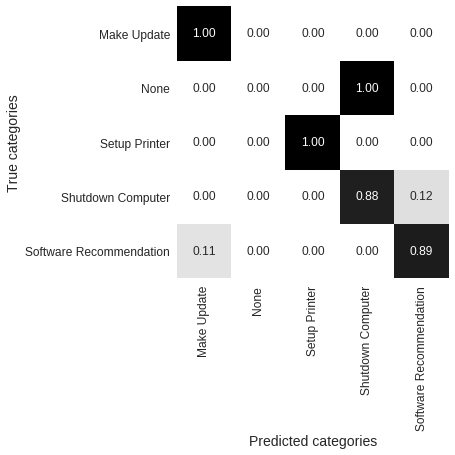

In [201]:
cm = confusion_matrix(y_true,y_pred)

matrix_proportions = np.zeros((5,5))
for i in range(0,5):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
#names=['hate speech','offensive','neither']
#names=['insult','non-insult','neither']
#names = ['ChangePassword', 'DeleteAccount', 'ExportData', 'FilterSpam', 'FindAlternative', 'SyncAccounts', 'None']
#names = ['gotoPlace','placeAccommodation','placeExplore','placeInformation','placeLogistics']
names = ['Make Update','None','Setup Printer','Shutdown Computer','Software Recommendation']
#names = ['P','N','O']

confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)


In [0]:
nlp.to_disk('spacy lg.bin')

In [191]:
!ls ./spacy\ lg.bin/vocab/vectors

./spacy lg.bin/vocab/vectors


In [0]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=names)


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class Word2Vectorizer(TransformerMixin):
    """
    Wrapper class for running word2vec into pipelines and FeatureUnions
    """
    def __init__(self,word2vec):
        self.word2vec=word2vec

    def fit(self,x, y=None):
        return self

    def transform(self, X):
        return self.word2vec(X)

      
#wv = Word2Vectorizer(tokenizeText)
#wv.fit_transform("hi how are you doing")

In [0]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, tokenizeText, num_features=300)
    return exp

def visualize_one_exp(features, labels, index, class_names = names):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)



In [237]:
pipe2 = Pipeline([
  ('word2vec_featurize', Word2Vectorizer),
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1",dual=False))),
  ('classification', LinearSVC(penalty="l2"))])
#visualize_one_exp(test_featurized['text'], test_featurized['intent'], 5)

explain_one_instance("Hi i want to fix my printer", names)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


IndexError: ignored